In [1]:
import tensorflow as tf
import numpy as np
import os
import glob
import time
import scipy.misc
import scipy.ndimage
import cv2
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# define SRCNN

batch_size = 128
img_size = 33
channel_size = 1
label_size = 21
learning_rate = 1e-4
dataset_dir = '/home/hsx/project/SRCNN_liu/data/Train/'
testset_dir = '/home/hsx/project/SRCNN_liu/data/Test/'
sample_dir = 'sample'
epochs = 15000
scale = 3
stride = 14 # The size of stride to apply input image
padding = 6
save_model_name = "SRCNN.model"
checkpoint_dir = "checkpoints"

weights = {
    'w1':tf.Variable(tf.random_normal([9,9,1,64], stddev=1e-3),name='w1'),
    'w2':tf.Variable(tf.random_normal([1,1,64,32], stddev=1e-3), name='w2'),
    'w3':tf.Variable(tf.random_normal([5,5,32,1], stddev=1e-3), name='w3')
}

bias = {
    'b1':tf.Variable(tf.zeros([64]),name='b1'),
    'b2':tf.Variable(tf.zeros([32]), name='b2'),
    'b3':tf.Variable(tf.zeros([1]), name='b3')
}

inputs = tf.placeholder(tf.float32,[None,img_size, img_size,channel_size],name='inputs')
labels = tf.placeholder(tf.float32,[None,label_size,label_size,channel_size],name='labels')

conv1 = tf.nn.relu(tf.nn.conv2d(inputs,weights['w1'],strides=[1,1,1,1],padding='VALID')+bias['b1'])
conv2 = tf.nn.relu(tf.nn.conv2d(conv1,weights['w2'],strides=[1,1,1,1],padding='VALID')+bias['b2'])
conv3 = tf.nn.relu(tf.nn.conv2d(conv2,weights['w3'],strides=[1,1,1,1],padding='VALID')+bias['b3'])

loss = tf.reduce_mean(tf.square(labels-conv3))
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [3]:
# define prepocess

def read_data(dataset_dir,stride):
    # get data
    filenames = os.listdir(dataset_dir)
    data_dir = os.path.join(os.getcwd(), dataset_dir)
    data = glob.glob(os.path.join(data_dir, "*.bmp"))
    sub_input_sequence = []
    sub_label_sequence = []
    sub_input_nx=[]
    sub_input_ny=[]

    for idx in range(len(data)):
        input_, label_ = load_data(data[idx], scale)
        h, w = input_.shape
        nx=0
        ny=0
        for x in range(0, h - img_size + 1, stride):
            nx+=1
            ny=0
            for y in range(0, w - img_size + 1, stride):
                # print(x,x + img_size)
                ny+=1
                sub_input = input_[x:x + img_size, y:y + img_size]  # [33,33]
                sub_label = label_[x + padding:x + padding + label_size,
                            y + padding:y + padding + label_size]  # [21,21] 最中间的21x21为label

                sub_input = sub_input.reshape([img_size, img_size, 1])
                sub_label = sub_label.reshape([label_size, label_size, 1])

                sub_input_sequence.append(sub_input)
                sub_label_sequence.append(sub_label)

        sub_input_nx.append(nx)
        sub_input_ny.append(ny)
    return sub_input_sequence, sub_label_sequence,sub_input_nx,sub_input_ny


def load_data(data_path, scale):
    img = scipy.misc.imread(data_path, flatten=True, mode='YCbCr').astype(np.float)
    label_ = modcrop(img, scale)  # 保证剩下的图像尺寸能够被整切出patch
    img = img / 255.
    label_ = label_ / 255.
    # 插值，得到模糊图像
    input_ = scipy.ndimage.interpolation.zoom(label_, (1. / scale), prefilter=False)
    input_ = scipy.ndimage.interpolation.zoom(input_, (scale / 1.), prefilter=False)
    return input_, label_


def modcrop(img, scale):
    h, w = img.shape
    h = h - np.mod(h, scale)
    w = w - np.mod(w, scale)
    img = img[0:h, 0:w]
    return img

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h*size[0], w*size[1], 1))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

In [4]:
# get the data for train

train_data, train_label, nx,ny = read_data(dataset_dir,stride)
print(len(train_data))

/home/hsx/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


21884


Start training......
Epoch: [0], Time: [1.97], Loss: [0.123146]
Epoch: [50], Time: [1.56], Loss: [0.002678]
Epoch: [100], Time: [1.49], Loss: [0.002511]
Epoch: [150], Time: [1.37], Loss: [0.002478]
Epoch: [200], Time: [1.39], Loss: [0.002455]
Epoch: [250], Time: [1.44], Loss: [0.002441]
Epoch: [300], Time: [1.52], Loss: [0.002433]
Epoch: [350], Time: [1.45], Loss: [0.002430]
Epoch: [400], Time: [1.39], Loss: [0.002428]
Epoch: [450], Time: [1.52], Loss: [0.002429]
Epoch: [500], Time: [1.49], Loss: [0.002427]
Epoch: [550], Time: [1.44], Loss: [0.002425]
Epoch: [600], Time: [1.38], Loss: [0.002422]
Epoch: [650], Time: [1.46], Loss: [0.002420]
Epoch: [700], Time: [1.49], Loss: [0.002418]
Epoch: [750], Time: [1.46], Loss: [0.002415]
Epoch: [800], Time: [1.43], Loss: [0.002413]
Epoch: [850], Time: [1.46], Loss: [0.002410]
Epoch: [900], Time: [1.50], Loss: [0.002407]
Epoch: [950], Time: [1.40], Loss: [0.002405]
Epoch: [1000], Time: [1.45], Loss: [0.002403]
Epoch: [1050], Time: [1.50], Loss: [

Epoch: [8950], Time: [1.50], Loss: [0.002143]
Epoch: [9000], Time: [1.45], Loss: [0.002143]
Epoch: [9050], Time: [1.50], Loss: [0.002143]
Epoch: [9100], Time: [1.54], Loss: [0.002142]
Epoch: [9150], Time: [1.46], Loss: [0.002142]
Epoch: [9200], Time: [1.44], Loss: [0.002141]
Epoch: [9250], Time: [1.43], Loss: [0.002141]
Epoch: [9300], Time: [1.37], Loss: [0.002141]
Epoch: [9350], Time: [1.40], Loss: [0.002141]
Epoch: [9400], Time: [1.39], Loss: [0.002140]
Epoch: [9450], Time: [1.38], Loss: [0.002140]
Epoch: [9500], Time: [1.47], Loss: [0.002140]
Epoch: [9550], Time: [1.51], Loss: [0.002140]
Epoch: [9600], Time: [1.38], Loss: [0.002139]
Epoch: [9650], Time: [1.33], Loss: [0.002139]
Epoch: [9700], Time: [1.46], Loss: [0.002139]
Epoch: [9750], Time: [1.48], Loss: [0.002139]
Epoch: [9800], Time: [1.44], Loss: [0.002138]
Epoch: [9850], Time: [1.33], Loss: [0.002138]
Epoch: [9900], Time: [1.44], Loss: [0.002138]
Epoch: [9950], Time: [1.48], Loss: [0.002138]
Epoch: [10000], Time: [1.51], Loss

/home/hsx/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


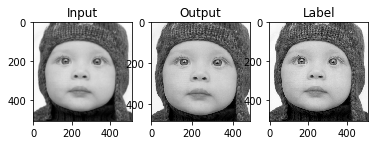

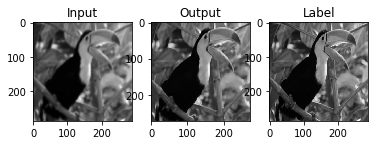

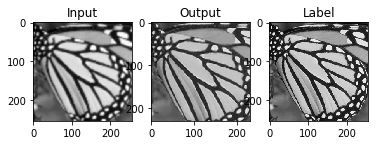

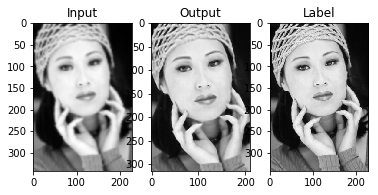

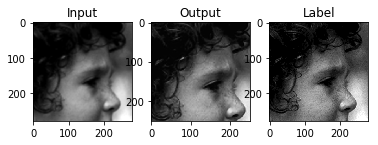

Start saving......
Finish!


In [5]:
# start training

print("Start training......")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        start_time = time.time()
        batch_idxs = len(train_data)//batch_size
        epoch_error = []
        for idx in range(batch_idxs):
            batch_images = train_data[idx*batch_size:(idx+1)*batch_size]
            # print(batch_images.shape)
            batch_labels = train_label[idx*batch_size:(idx+1)*batch_size]
            _, batch_loss,batch_conv3 = sess.run([train_op,loss,conv3],feed_dict={inputs:batch_images,labels:batch_labels})
            epoch_error.append(batch_loss)
            '''
            if idx %10 == 0:
                print("Epoch: [%d], batch: [%d], loss: [%f]" % (epoch,idx,batch_loss))
            '''
        if epoch % 50 == 0:
            print("Epoch: [%d], Time: [%4.2f], Loss: [%f]" % (epoch,time.time()-start_time,np.mean(epoch_error)))


    print("Start testing......")
    test_data, test_label, nx, ny = read_data(testset_dir, stride=21)
    _, test_conv3 = sess.run([train_op, conv3],
                             feed_dict={inputs: test_data, labels: test_label})
    filenames = os.listdir(testset_dir)
    data_dir = os.path.join(os.getcwd(), testset_dir)
    data = glob.glob(os.path.join(data_dir, "*.bmp"))
    for idx in range(len(data)):
        test_input_, test_label_ = load_data(data[idx], scale)
        result = merge(test_conv3[0:nx[idx]*ny[idx]], [nx[idx], ny[idx]])
        test_conv3 = test_conv3[nx[idx]*ny[idx]:]
        result = result.squeeze()  # to squeeze to one channel
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(test_input_,cmap='gray')
        plt.title("Input")
        plt.subplot(1,3,2)
        plt.imshow(result,cmap='gray')
        plt.title("Output")
        plt.subplot(1,3,3)
        plt.imshow(test_label_,cmap='gray')
        plt.title("Label")
        plt.show()
        image_path = os.path.join(os.getcwd(), sample_dir)
        image_path = os.path.join(image_path, "test_image_%d_output.png" % idx)
        # scipy.misc.imsave(result, image_path)
        cv2.imwrite(image_path, test_label_ * 255.)  # imwrite range(0,255)
        

    print("Start saving......")
    saver = tf.train.Saver()
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    saver.save(sess, os.path.join(checkpoint_dir, save_model_name))
    print("Finish!")

In [6]:
print("Copyright @ Liu Junling")

Copyright @ Liu Junling
